In [23]:
%load_ext autoreload
%autoreload 2
from solvers import *
from formula_generation import *
from statistics_utils import StatisticsModule
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Benchmarks

In this notebook I will investigate the performance of the implemented algorithms.

The main metric for this will be the time spent to solve certain input formulas, but other metrics such as the number of unit propagations, decisions or restarts will give further insight into why some algorithms may perform better than others. To get the statistics, the solvers are tested on 100 randomly generated logical formulas and their performance metrics are averaged across those 100 tests. Those randomly generated formulas also have different sizes for which the size is influenced by 3 parameters: n,c and k. n is the number of variables in a formula, c is the number of unique clauses and k is the number of literals per clause.

The y-axes on almost all plots are log-scaled.

## Different values for n, c, k

Since this is important for every other chapter, I would like to first investigate what would be good formulas to test my solvers on.

Let c = $\gamma$ $\cdot$ n.

It has been shown that $\gamma$ = 4.26 is a good value to get a fairly equal distribution of satisfiable and unsatisfiable formulas. Therefore this leads to especially hard formula instances since they aren't trivially satisfiable or unsatisfiable. (see: https://doi.org/10.1016/0004-3702(95)00051-8.) 

Let's test if this is true for the formulas I will be working with.

In [19]:
def plot_different_gammas(k, gammas, ns=[10,20,30,40,50,60],num_tests=100):
    solvers = [cdcl_clause_minimization_and_deletion]
    stats_module = StatisticsModule(k=k,use_timeouts=False,num_tests=num_tests)
    for gamma in gammas:
        stats_module.gamma = gamma
        different_k_stats = stats_module.get_average_statistics_for_multiple_n(ns,solvers)
        values = stats_module.get_values_per_solver(different_k_stats,ns,"SAT")
        for _, stat_values in values.items():
            plt.plot(ns[0:len(stat_values)],stat_values,label=f"gamma={gamma}")
    
    plt.axhline(y=0.5, color='k', linestyle='--')
    plt.yscale("linear")
    plt.xlabel("n")
    plt.ylabel("SAT %")
    plt.legend()
    plt.title("SAT %" + f" for different c_multipliers for different n (k={k})")
    plt.show()

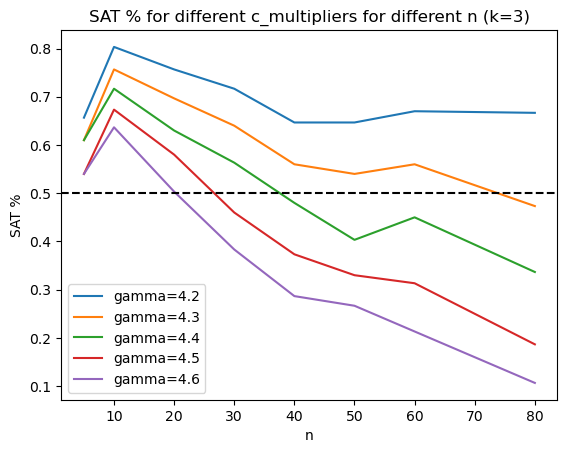

In [20]:
plot_different_gammas(3,[4.2,4.3,4.4,4.5,4.6],ns=[5,10,20,30,40,50,60,80],num_tests=300)

It seems like $\gamma$=4.26 might be too low for smaller formulas but generally works well for formulas larger than n=70. \
For formulas n<=40, a value of $\gamma$≈4.5 may be better suited.

Later, I am also going to work with instances of 2-SAT so let's also find good values for 2-SAT.

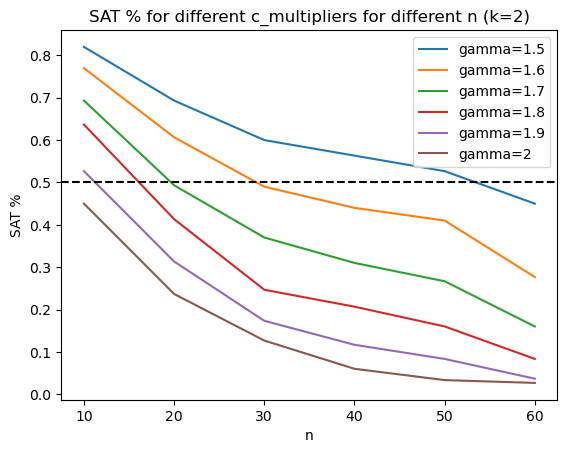

In [3]:
plot_different_gammas(2,[1.4,1.5,1.6,1.7,1.8,1.9,2])

It seems like the value of $\gamma$ is dependent on the number of variables. While a value of $\gamma$≈1.9 seems best for n=10, a value of $\gamma$≈1.48 is best for n=60.

The best values for each $\gamma$ are approximately:
| n | $\gamma$ | 
|----------|----------|
| 10 | 1.92 |
| 20 | 1.7 |
| 30 | 1.6|
| 40 | 1.55 |
| 50 | 1.5 |
| 60 | 1.48 |

## General Comparison of Solvers

### Correctness

First of all though, let's check if the algorithms return correct results for a couple of random formulas. To do so, results are validated against results of the cadical sat solver.

In [2]:
stats_module = StatisticsModule(check_correctness=True)

stats_module.solver_statistics(60,solve_2_sat,c=1.48*60,k=2)

solvers = [dpll,davis_putnam,cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
for n,c,k in [(10,45,3),(1,1,1)]:
        for solver in solvers:
            stats_module.solver_statistics(n,solver,c=c,k=k)

print("All tests passed!")

All tests passed!


### Comparing all solvers

Now let's do a simple comparison of the solver speeds. I will omit the 2_sat_solver from lab 2 for this as it can't solve every formula. The following tests only use small values for n as some of the solvers are too bad for larger ones.

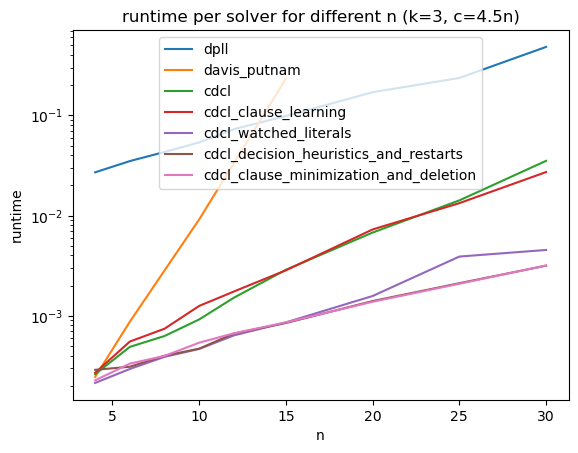

In [7]:
solvers = [dpll,davis_putnam,cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [4,6,8,10,12,15,20,25,30]
stats_module = StatisticsModule(gamma=4.5)
all_solver_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers)
stats_module.plot_statistic(all_solver_statistics,ns,"runtime")

It seems that none of the cdcl implementations is a clear winner in this comparison with small values for n but those with watched literals are better than the ones without. Clearly, the davis putnam and DPLL algorithms are not competitive with any of the cdcl implementations though.

Except for very small formulas, where my davis putnam implementation was actually able to keep up with the cdcl implementations. It still falls off very quickly though and starts timing out at formulas with just 15 variables. At this point, DPLL is still able to solve them in time.

Also, DPLL is clearly worse than all CDCL implementations in terms of runtime for any formula but I would personally suspect that this could be mainly due to its recursive implementation which requires a lot of recomputations to prevent memory issues. Maybe the number of propagations will give further insights into that.

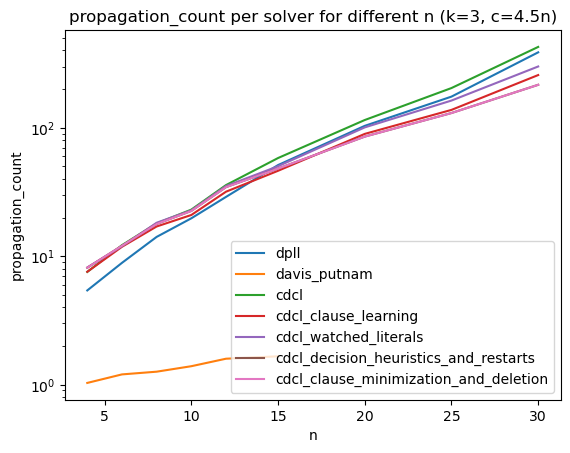

In [8]:
stats_module.plot_multiple_statistics(all_solver_statistics,ns,["propagation_count"])

Yes, I was correct! In terms of necessary unit propagations, DPLL was very similar to the cdcl implementations.

Also, it seems like the davis putnam algorithm does significantly less unit propagations but I don't think this means a lot since this was just an enhancement of the algorithm and isn't a heavy part of the computation load.

### Investigation of outliers

Outliers may have a large impact on the results when looking at random samples and using averaging across those tests. Let's have a brief look into how largely this impacts the results when using 100 test cases.

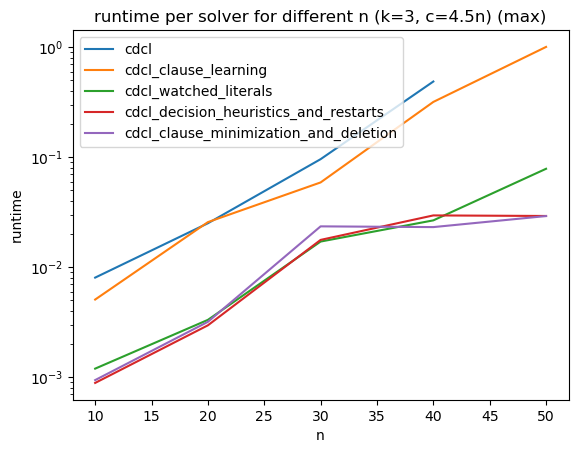

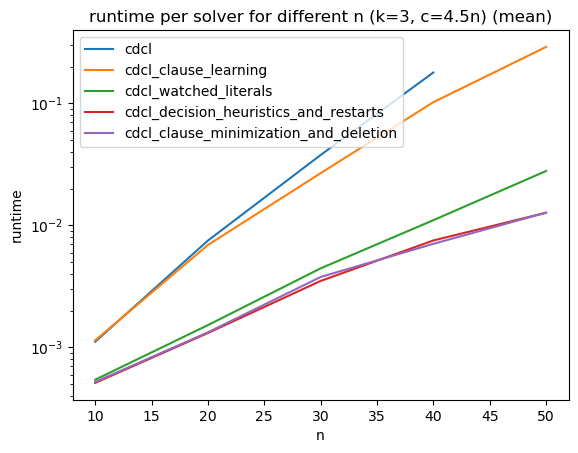

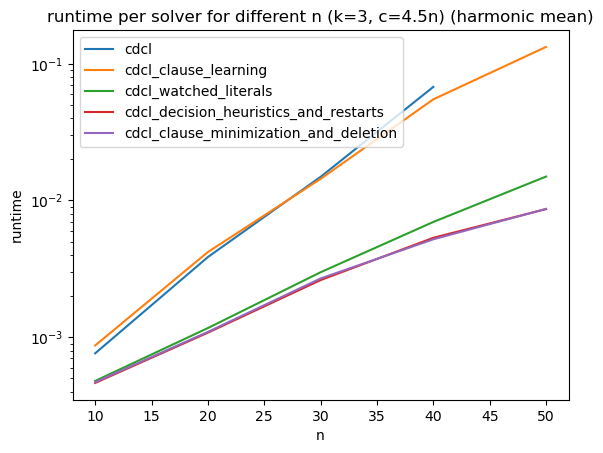

In [16]:
solvers = [cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [10,20,30,40,50]
stats_module = StatisticsModule(gamma=4.5,seed=42)
outlier_statistics = stats_module.get_statistics_for_multiple_n(ns,solvers)
stats_module.averaging_function = np.max
stats_module.plot_statistic(stats_module.average_statistics(outlier_statistics),ns,"runtime"," (max)")
stats_module.averaging_function = np.mean
stats_module.plot_statistic(stats_module.average_statistics(outlier_statistics),ns,"runtime"," (mean)")
stats_module.averaging_function = stats.hmean
stats_module.plot_statistic(stats_module.average_statistics(outlier_statistics),ns,"runtime"," (harmonic mean)")

The impact of outliers is not as big as I thought. Maximum values are not heavily reflected in the mean values. It seems that testing with about 100 instances is fairly sufficient for stable results but of course, using more is always better.

One more idea I had to create more stable results would be to use a different averaging method like the harmonic mean which weights outliers less strongly. But on the other hand, outliers are an essential part of investigating solver performance and should not be neglected. For example, when having to solve a number of completely random formulas, one is likely most interested in the total time needed to solve all of them and using a harmonic mean would not accurately reflect this information need. Therefore I will keep using the arithmetic mean even though it might not yield the most stable results given that I don't want to leave my computer running for an eternity :).

### Comparing the different CDCL iterations

With each iteration of the CDCL implementations, new features were added with the intention of improving last iteration's performance. Let's find out if this was successful.

In [3]:
solvers = [cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [10,20,30,40,50,60,70,80,90,100,120]
stats_module = StatisticsModule(timeout_threshold=120)
avg_cdcl_stats = stats_module.get_average_statistics_for_multiple_n(ns,solvers)

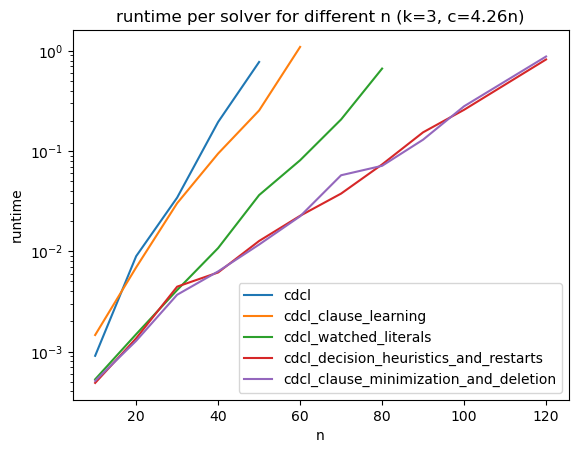

In [4]:
stats_module.plot_statistic(avg_cdcl_stats,ns,"runtime")

As expected, with almost every iteration of the cdcl implementations, the runtime improves. Only the last addition of clause minimization and deletion does not seem to offer a particularly great increase in performance compared to its predecessor with decision heuristics and restarts and also performs worse on a lot of formulas.

Now let's have a look at statistics propagation_count, decision_count, conflict_count, restart_count, deleted_clause_count and minimized_clause_count. These might provide further insights into how the solvers work.

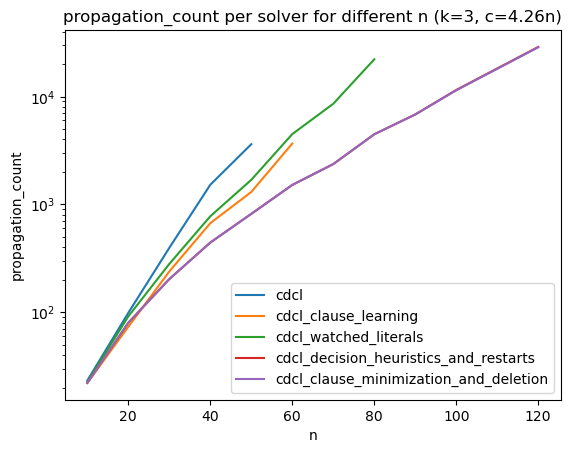

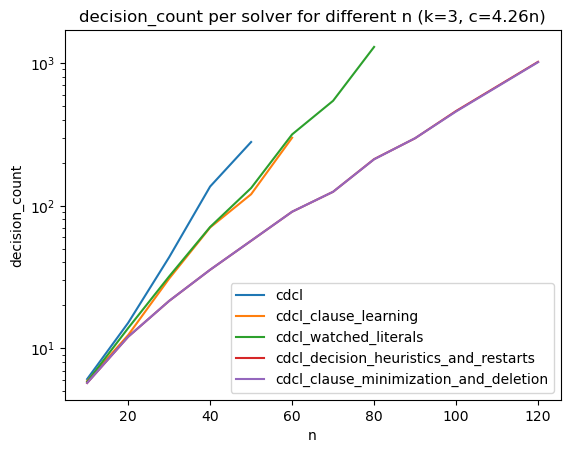

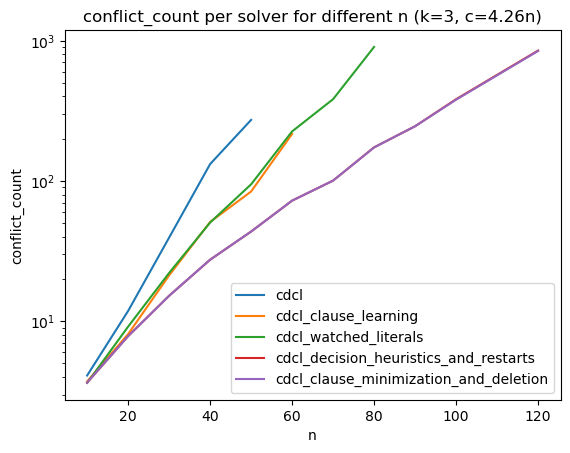

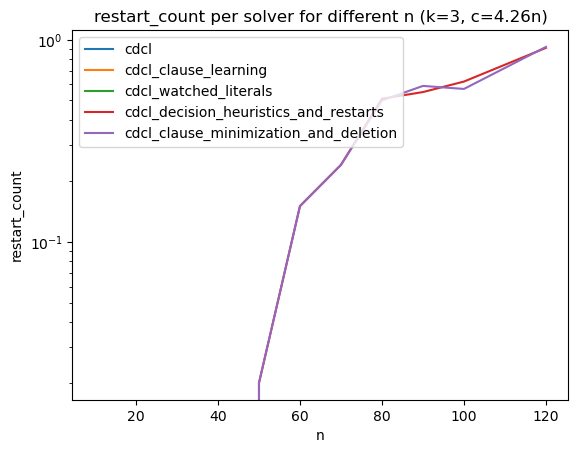

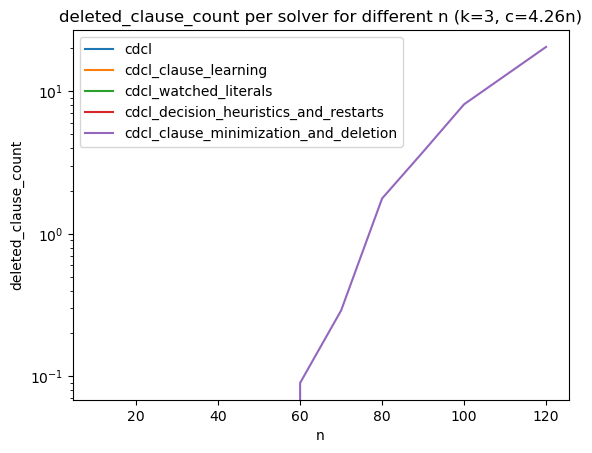

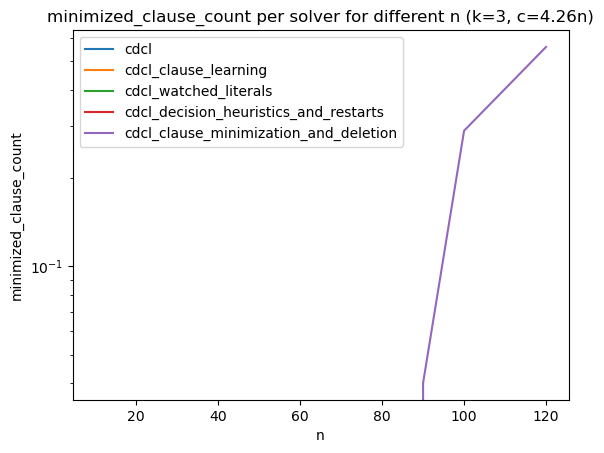

In [5]:
stats_module.plot_multiple_statistics(avg_cdcl_stats,ns,["propagation_count", "decision_count", "conflict_count", "restart_count", "deleted_clause_count","minimized_clause_count"])

Most of these results are fairly expectable. Increased numbers of propagations, conflicts and decisions seem to be heavily correlated to a worse performance and all of the statistics increase with bigger values of n. It's also interesting that the graphs of the statistics propagation_count, conflict_count and decision_count look very similar, just with a different y-values. This make sense though, since more conflicts also lead to more decisions and unit propagations. \
It seems that restarts (and therefore also clause deletions) start to be applied around values of n=60 and clause minimizations at n=90.

Interestingly, the statistics of cdcl_clause_learning and cdcl_watched_literals are not the same even though I only changed the implementation of the unit propagations. I suppose this is due to a differing order of unit propagations but maybe there is also something else I'm missing. The results are still extremely similar though so I doubt the implementation is wrong.

Also, the statistics of the solvers cdcl_decision_heuristics_and_restarts and cdcl_clause_minimization_and_deletion are actually almost identical so clause minimizations and deletion don't seem to hurt or improve the solver by much. \
I suspect the reason why deleting clauses didn't have much of an impact is because clauses are only deleted with each restart. And since there aren't that many restarts happening in the first place, not that many clauses are actually being deleted. This could be changed by using larger formulas, but running those on my machine takes a very long time, so I don't want to. \
Similarly, not many clauses are being minimized on these small formulas so it seems unlikely for clause minimization to have a particularly large positive effect on the performance. But at least the benefit of minimizing at least some clauses was able to outweigh the work necessary to check if they can be minimized in the first place. That seems like a positive outcome to me and leaves to suspect that clause minimization may be worth it for larger formulas.

### Comparing performance vs. the simple 2-SAT solver

The simple 2-SAT solver from the 2nd lab session can only solve 2-SAT problems. Nevertheless it would still be interesting to see if this makes it more optimal to solve this specific field of problems more efficiently than the other generalized solvers. \
According to my investigation in the beginning, a good value for $\gamma$ would be ~1.55 for the formulas I am working with.

In [13]:
solvers = [solve_2_sat,dpll,cdcl,cdcl_watched_literals,cdcl_clause_minimization_and_deletion]
ns = [10,20,30,40,50,60]
stats_module = StatisticsModule(gamma=1.55,k=2,num_tests=500)
avg_2_sat_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers)

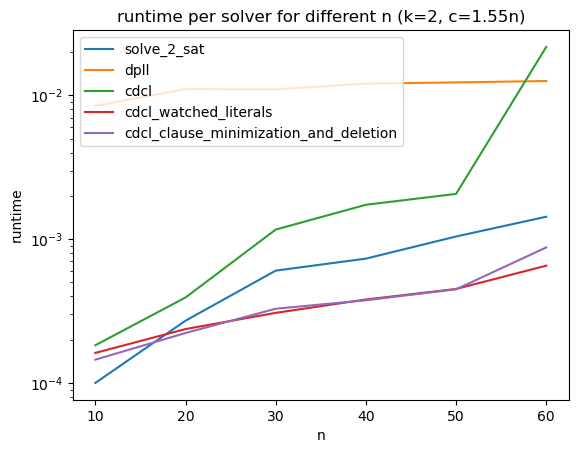

In [14]:
stats_module.plot_statistic(avg_2_sat_statistics,ns,"runtime")

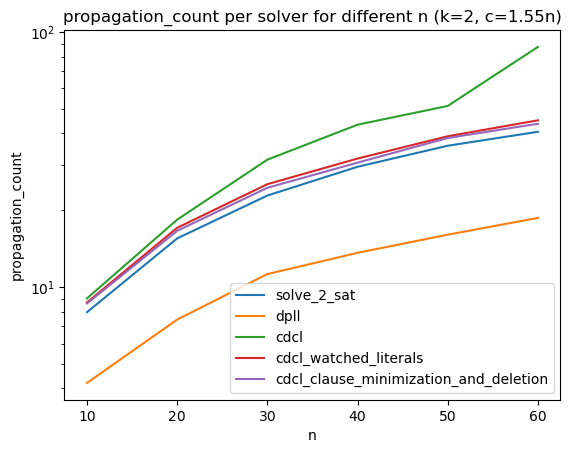

In [15]:
stats_module.plot_statistic(avg_2_sat_statistics,ns,"propagation_count")

Yes, our simple 2-SAT solver is actually able to keep up with most of the implementations. It's faster for smaller formulas than all other solvers up until values of n=20. Afterwards, the CDCL implementations with watched literal unit propagation beat the 2-SAT solver. In terms of propagation count, all solvers except DPLL have very similar values, DPLL requires significantly less unit propagations, so in theory, DPLL could probably be the best for this if it wasn't implemented recursively.

## Deep-Dive into specific solver hyperparameters

### Formula Preprocessing in Davis Putnam

In Lab 3, we implemented numerous different formula processing techniques such as removing doubles and tautologies, eliminating pure literals, unit propagation and performing subsumptions to enhance the davis putnam algorithm. Let's see how each of the techniques influences the solver's performance. Do they even help?

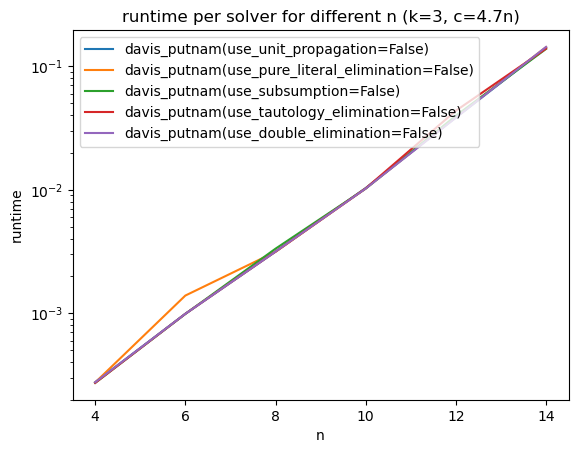

In [21]:
solvers = [davis_putnam,davis_putnam,davis_putnam,davis_putnam,davis_putnam]
solver_args = [{'use_unit_propagation':False},{'use_pure_literal_elimination':False},{"use_subsumption":False},{"use_tautology_elimination":False},{"use_double_elimination":False}]
ns = [4,6,8,10,12,14]
stats_module = StatisticsModule(gamma=4.7)
dp_processing_stats = stats_module.get_average_statistics_for_multiple_n(ns,solvers,solver_args=solver_args)
stats_module.plot_multiple_statistics(dp_processing_stats,ns,["runtime"])

It seems that none of the processing techniques have a particularly great impact on the performance of davis putnam. This means that most of the work is done by resolution.

### DPLL

In Lab 4 (DPLL), we wanted to compare DPLL's performance when using pure literal elimination vs. without it. Let's investigate this by comparing the solving speed of the 2 DPLL versions and then looking at statistics such as the numbers of unit propagations, pure literal eliminations and decisions necessary to solve the formulas.

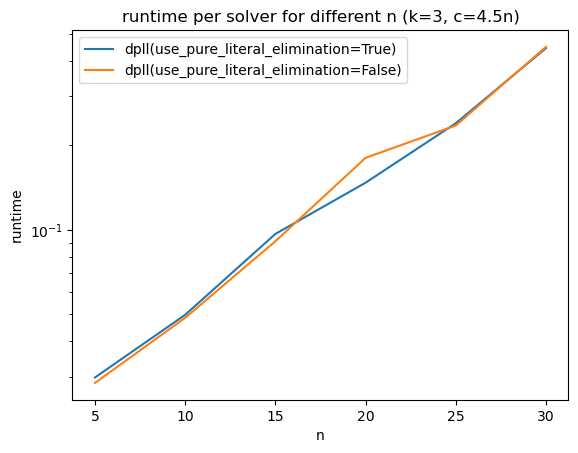

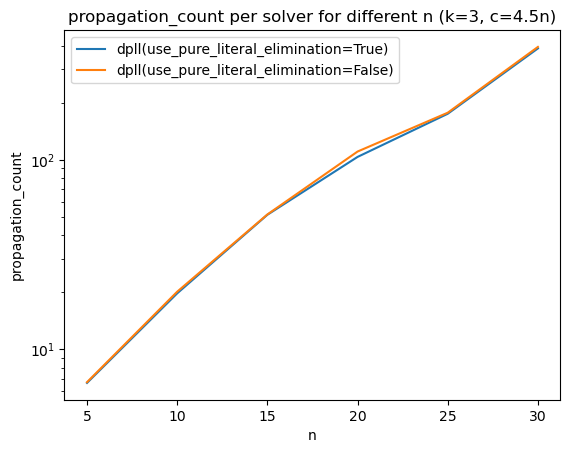

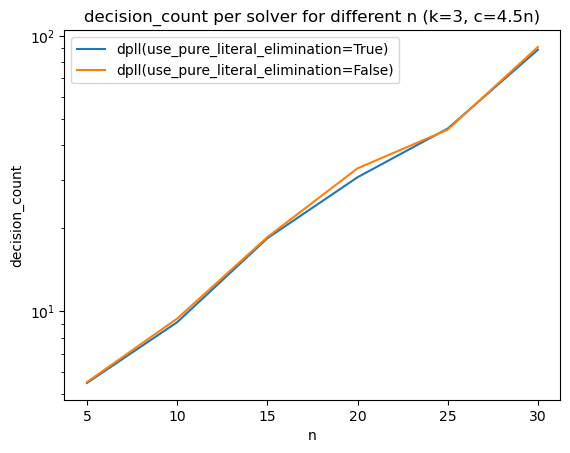

In [24]:
solvers = [dpll,dpll]
solver_args = [{'use_pure_literal_elimination':True},{'use_pure_literal_elimination':False}]
ns = [5,10,15,20,25,30,40]
stats_module = StatisticsModule(gamma=4.5)
dpll_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers,solver_args=solver_args)
stats_module.plot_multiple_statistics(dpll_statistics,ns,["runtime","propagation_count","decision_count"])

It seems that using pure literal elimination does improve dpll's performance but only by a small margin. As expected, using pure literal elimination lowers the amount of necessary unit propagations and decisions. 

I would personally suspect that these performance results are mainly due to an inefficient implementation of unit propagation used in the dpll algorithm. A faster implementation using watched literals may imply that pure literal elimination is not worth-it.

### Decision heuristics

Let's have a look into how VSIDS and Phase saving affects the performance of the CDCL solver.

In [25]:
solvers = [cdcl_decision_heuristics_and_restarts, cdcl_decision_heuristics_and_restarts]
solver_args = [{'use_decision_heuristics':True,'use_restarts':False},{'use_decision_heuristics':False,'use_restarts':False}]
stats_module = StatisticsModule(gamma=4.35)
ns = [10,20,30,40,50,60,70]
avg_decision_heuristics_stats = stats_module.get_average_statistics_for_multiple_n(ns,solvers,solver_args=solver_args)

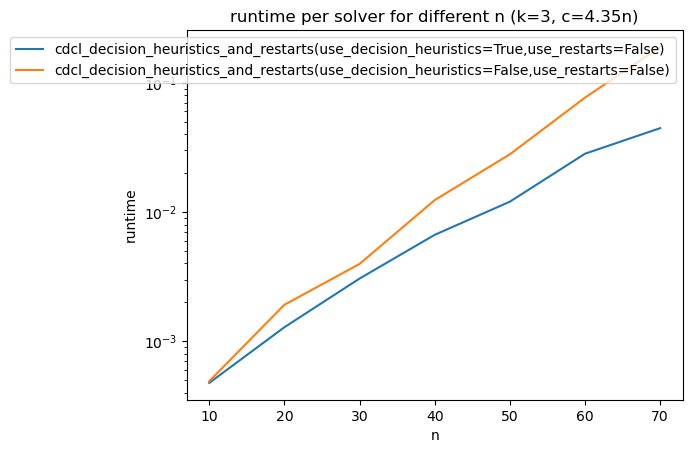

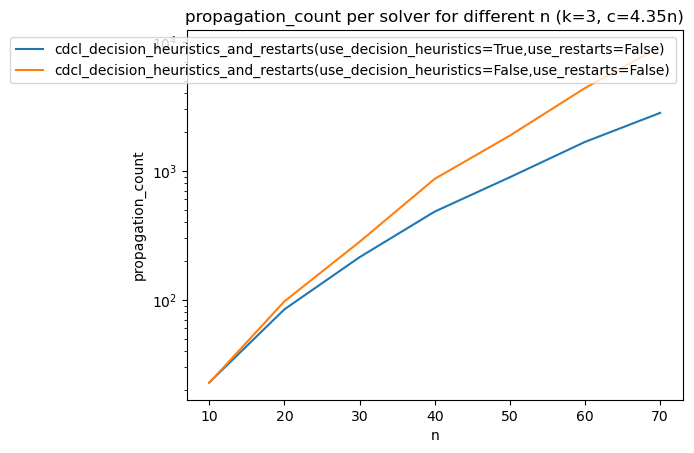

In [26]:
stats_module.plot_statistic(avg_decision_heuristics_stats,ns,"runtime")
stats_module.plot_multiple_statistics(avg_decision_heuristics_stats,ns,["propagation_count"])

So using the decision heuristics does have a large impact on the performance. The solver becomes faster and requires less unit propagations.

### Restarts

The 4th iteration of my CDCL implementations features restarting and decision heuristics. As we've just seen, the decision heristics have a big impact on the performance and this may have cluttered the comparison of the iterations. Therefore I wonder how large the impact of just the restarts actually is and for which formula sizes restarts become actually worth-it. Also, let's see if choosing a different parameter for c, which influences the restart frequency, would improve the performance.

In [12]:
solvers = [cdcl_decision_heuristics_and_restarts, cdcl_decision_heuristics_and_restarts,cdcl_decision_heuristics_and_restarts,cdcl_decision_heuristics_and_restarts,cdcl_decision_heuristics_and_restarts]
solver_args = [{'use_restarts':False},{'c':25},{'c':50},{'c':75},{'c':100}]
stats_module = StatisticsModule(use_timeouts=False)
ns = [60,70,80,90,100,120]
restart_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers,solver_args=solver_args)

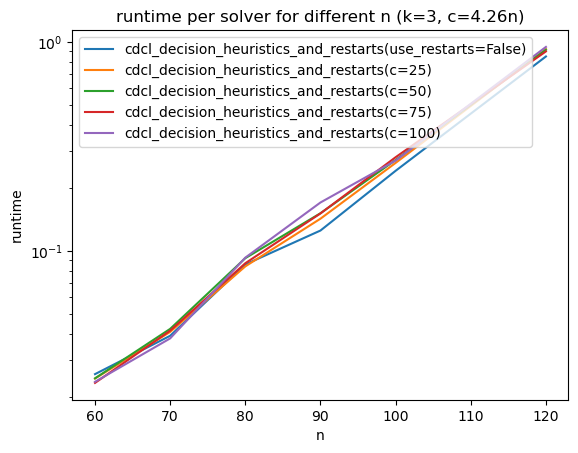

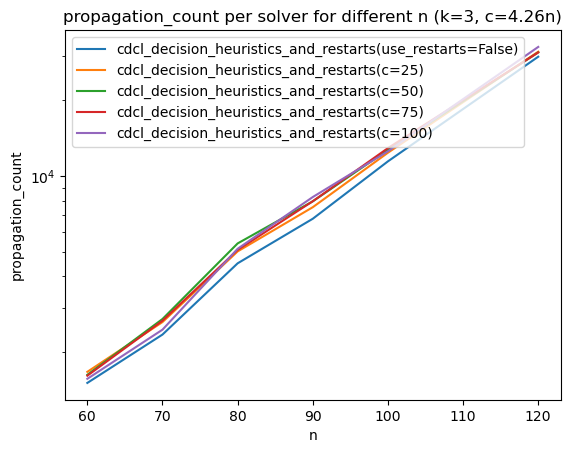

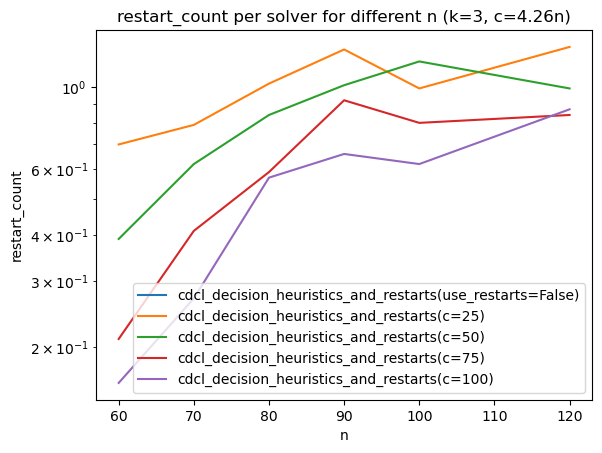

In [13]:
stats_module.plot_statistic(restart_statistics,ns,"runtime")
stats_module.plot_multiple_statistics(restart_statistics,ns,["propagation_count","restart_count"])

On the formulas I tested this on, restarts didn't really make a big difference in performance. This is most likely due to the fact that there aren't even that many restarts happening in the first place. Even with the threshold for restarts being a quarter of the default, only about 1 restart was performed on the largest formulas on average. The formulas I'm testing on are just too small to require many restarts. And while I would have liked to test this with larger formulas, running this already took a long time so I won't do it.

## Pigeonhole and Pebbling

To get a better feeling of the actual differences, this chapter uses regular linear scaled y-axes for its plots.

### Pebbling

As publicly known, pebbling formulas are hard for tree-like resolution but easy for generalized resolution. CDCL is somewhat comparable to generalized resolution while DPLL is equivalent to tree-like resolution. Can we see this difference reflected in their performance? I will compare the number of unit propagations as this metric is not heavily influenced by the implementation.

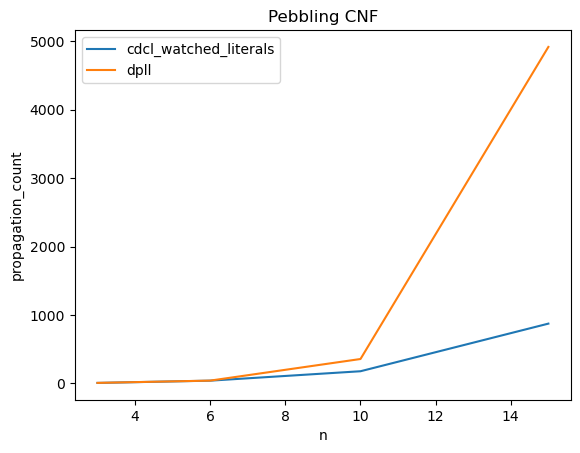

In [4]:
solvers = [cdcl_watched_literals, dpll]
ns = [3,6,10,15]
stats_module = StatisticsModule(use_timeouts=False,formula_creator=pebbling_cnf,num_tests=10)
pebbling_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers)
stats_module.plot_statistic(pebbling_statistics,ns,"propagation_count",title="Pebbling CNF",yscale="linear")

CDCL actually requires significantly less unit propagations than DPLL and it does look like there is an exponential difference between the 2 solvers.

### Pigeonhole

Pigeonhole formulas are hard for any solver based on resolution. Can we see this reflected in the propagation count?

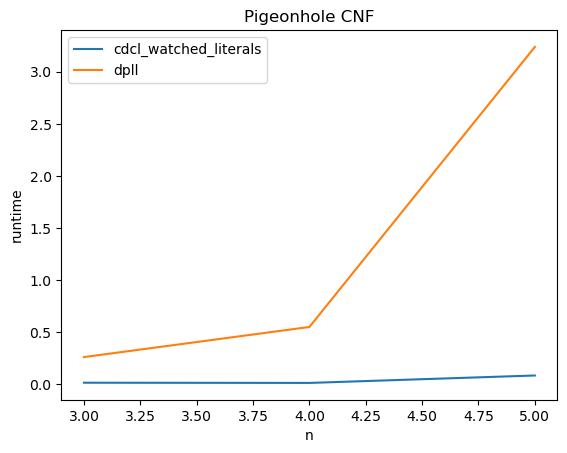

In [2]:
solvers = [cdcl_watched_literals, dpll]
ns = [3,4,5]
stats_module = StatisticsModule(use_timeouts=False,formula_creator=pigeonhole_cnf,num_tests=10)
pigeonhole_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers)
stats_module.plot_statistic(pigeonhole_statistics,ns,title="Pigeonhole CNF",yscale="linear")

The results seem very similar to the ones with the pebbling formulas. It is still remarkable though that CDCL takes a long time to solve such small formulas. Let's see at which point it take more than a minute to solve the pigeonhole formula 10 times.

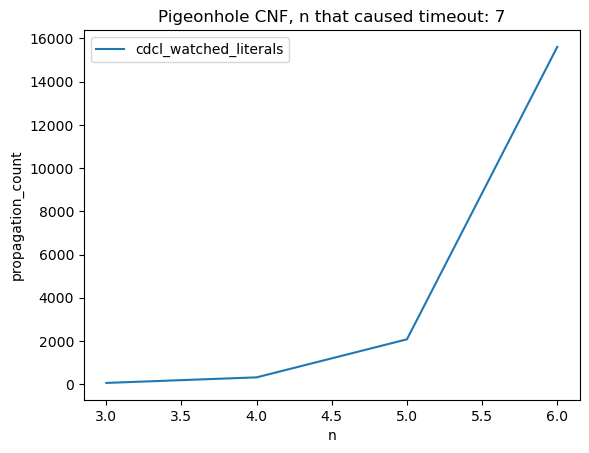

In [6]:
solvers = [cdcl_watched_literals]
ns = [3,4,5,6,7,8,9,10,11,12]
stats_module = StatisticsModule(timeout_threshold=60,formula_creator=pigeonhole_cnf,num_tests=10)
pigeonhole_statistics = stats_module.get_average_statistics_for_multiple_n(ns,solvers)
values = stats_module.get_values_per_solver(pigeonhole_statistics,ns,"runtime")["cdcl_watched_literals"]
n_that_caused_timeout = ns[len(values)]
stats_module.plot_statistic(pigeonhole_statistics,ns,"propagation_count",title=f"Pigeonhole CNF, n that caused timeout: {n_that_caused_timeout}",yscale="linear")

This looks so much like an exponential relationship with regards to n!